#**Importing Libraries**

In [1]:
# Install OpenCV
!pip install opencv-python

In [2]:
import torch
import torch.nn as nn
from torch.nn import Conv2d
import torch.nn.functional as F
from torchvision import transforms

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Concatenate, Activation, AveragePooling2D, MaxPooling2D

import os
import cv2
import random
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


In [3]:
thresh = 9.54321

#**Linear Interpolation**

In [4]:
def linear_interpolation(image, new_height, new_width):
    orig_height, orig_width = image.shape[:2]
    sx = new_width / orig_width
    sy = new_height / orig_height
    output_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    return output_image

def add_white_pixels(image, x_pixels, y_pixels):
    h, w = image.shape[:2]
    output_image = image.copy()
    output_image = cv2.copyMakeBorder(output_image, y_pixels, y_pixels, x_pixels, x_pixels, cv2.BORDER_CONSTANT, value=[255, 255, 255])

    return output_image

### **Modified Multi-Contrastive Loss Function**

In [5]:
class MultiContrastiveLoss(nn.Module):

    def __init__(self, margin):
        super(MultiContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, euclidean_distance_1, euclidean_distance_2, euclidean_distance_3, output):
        alpha = 0.5
        beta = 0.3
        gamma = 0.2

        combined_distance = alpha * euclidean_distance_1 + beta * euclidean_distance_2 + gamma * euclidean_distance_3
        print("c : ", combined_distance)
        genuine_loss = (output * combined_distance ** 2).mean()
        forged_loss = ((1 - output) * torch.clamp(self.margin - combined_distance, min=0) ** 2).mean()
        loss = genuine_loss + forged_loss

        return loss


#**Image Processing**

In [6]:
# For the reference image (Genuine image)
def image_processing_genuine(folder_no, folder_path):

  # Getting list of all images in the folder
  all_images = [img for img in os.listdir(folder_path) if img.endswith('.tif')]

  # Defining the sequence ranges
  start_seq = "H-S-" + str(folder_no) + "-G-01"
  end_seq = "H-S-" + str(folder_no) + "-G-24"

  filtered_images = [img for img in all_images if start_seq <= img <= end_seq]

  if filtered_images:
      img_name_genuine = random.choice(filtered_images)
      img_path = os.path.join(folder_path, img_name_genuine)
      genuine = cv2.imread(img_path)
      gray = cv2.cvtColor(genuine, cv2.COLOR_BGR2GRAY)
      _, threshold = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

      contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

      x_min, y_min, x_max, y_max = float('inf'), float('inf'), 0, 0
      for contour in contours:
          x, y, w, h = cv2.boundingRect(contour)
          x_min = min(x_min, x)
          y_min = min(y_min, y)
          x_max = max(x_max, x + w)
          y_max = max(y_max, y + h)

      cropped_image_genuine = genuine[y_min:y_max, x_min:x_max]
      cropped_image_genuine_name = img_name_genuine.replace(".tif", "_cropped.tif")
      cv2.imwrite(cropped_image_genuine_name, cropped_image_genuine)
      cv2.rectangle(genuine, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

      plt.imshow(genuine)
      plt.title(f"{img_name_genuine} with Single Bounding Box")
      plt.axis("off")
      plt.show()
  else:
      print("No images found in the specified sequence ranges.")

  return cropped_image_genuine_name


In [7]:
# For the test image (Genuine/Forged image)
def image_processing_genforg(folder_no, folder_path):

  all_images = [img for img in os.listdir(folder_path) if img.endswith('.tif')]

  genuine_start_seq = "H-S-" + str(folder_no) + "-G-01"
  genuine_end_seq = "H-S-" + str(folder_no) + "-G-24"
  forged_start_seq = "H-S-" + str(folder_no) +"-F-01"
  forged_end_seq = "H-S-" + str(folder_no) + "-F-30"

  # Filtering images within the specified sequence range
  filtered_images = [
      img for img in all_images if (genuine_start_seq <= img <= genuine_end_seq) or (forged_start_seq <= img <= forged_end_seq)
  ]

  # Selecting a random image from the filtered list

  label = 0

  if filtered_images:
      img_name_genforg = random.choice(filtered_images)

      for letter in img_name_genforg:
          if letter == "G":
              label = 1

      img_path = os.path.join(folder_path, img_name_genforg)
      gen_forg = cv2.imread(img_path)
      gray = cv2.cvtColor(gen_forg, cv2.COLOR_BGR2GRAY)
      _, threshold = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

      contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

      x_min, y_min, x_max, y_max = float('inf'), float('inf'), 0, 0
      for contour in contours:
          x, y, w, h = cv2.boundingRect(contour)
          x_min = min(x_min, x)
          y_min = min(y_min, y)
          x_max = max(x_max, x + w)
          y_max = max(y_max, y + h)

      cropped_image_genforg = gen_forg[y_min:y_max, x_min:x_max]
      cropped_image_genforg_name = img_name_genforg.replace(".tif", "_cropped.tif")
      cv2.imwrite(cropped_image_genforg_name, cropped_image_genforg)
      cv2.rectangle(gen_forg, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

      plt.imshow(gen_forg)
      plt.title(f"{img_name_genforg} with Single Bounding Box")
      plt.axis("off")
      plt.show()
  else:
      print("No images found in the specified sequence ranges.")

  return cropped_image_genforg_name, label


In [8]:
# Resizing Reference image (Genuine)
def resizing_genuine(cropped_image_genuine_name):

  image_genuine = cv2.imread(cropped_image_genuine_name)
  img_name_genuine = cropped_image_genuine_name.replace("_cropped.tif", ".tif")

  resized_image_1_genuine = linear_interpolation(image_genuine, 50, 150)
  image_with_white_pixels_1_genuine = add_white_pixels(resized_image_1_genuine, 0, 0)
  image_with_white_pixels_2_genuine = add_white_pixels(resized_image_1_genuine, 15, 5)
  image_with_white_pixels_3_genuine = add_white_pixels(resized_image_1_genuine, 30, 10)

  img_resized_1_genuine = f"/content/{img_name_genuine.replace('.tif', '_resized_1.tif')}"
  img_resized_2_genuine = f"/content/{img_name_genuine.replace('.tif', '_resized_2.tif')}"
  img_resized_3_genuine = f"/content/{img_name_genuine.replace('.tif', '_resized_3.tif')}"

  cv2.imwrite(img_resized_1_genuine, image_with_white_pixels_1_genuine)
  cv2.imwrite(img_resized_2_genuine, image_with_white_pixels_2_genuine)
  cv2.imwrite(img_resized_3_genuine, image_with_white_pixels_3_genuine)

  return [img_resized_1_genuine, img_resized_2_genuine, img_resized_3_genuine]

In [9]:
# Resizing test image (Genuine/Forged)
def resizing_genforg(cropped_image_genforg_name):

  image_genforg = cv2.imread(cropped_image_genforg_name)
  img_name_genforg = cropped_image_genforg_name.replace("_cropped.tif", ".tif")

  resized_image_1_genforg = linear_interpolation(image_genforg, 50, 150)
  image_with_white_pixels_1_genforg = add_white_pixels(resized_image_1_genforg, 0, 0)
  image_with_white_pixels_2_genforg = add_white_pixels(resized_image_1_genforg, 15, 5)
  image_with_white_pixels_3_genforg = add_white_pixels(resized_image_1_genforg, 30, 10)

  img_resized_1_genforg = f"/content/{img_name_genforg.replace('.tif', '_resized_1.tif')}"
  img_resized_2_genforg = f"/content/{img_name_genforg.replace('.tif', '_resized_2.tif')}"
  img_resized_3_genforg = f"/content/{img_name_genforg.replace('.tif', '_resized_3.tif')}"

  cv2.imwrite(img_resized_1_genforg, image_with_white_pixels_1_genforg)
  cv2.imwrite(img_resized_2_genforg, image_with_white_pixels_2_genforg)
  cv2.imwrite(img_resized_3_genforg, image_with_white_pixels_3_genforg)

  return [img_resized_1_genforg, img_resized_2_genforg, img_resized_3_genforg]

In [10]:
# Converting images to tensor
def converting_images_to_tensor(genuine_list, genforg_list):

  transform = transforms.Compose([transforms.ToTensor()])
  image_tensors_genuine = []
  image_tensors_genforg = []

  for genuine in genuine_list:
    image = Image.open(genuine)
    img_tensor = transform(image)
    image_tensors_genuine.append(img_tensor)
    # print(f"{genuine}: {img_tensor.shape}")

  for genforg in genforg_list:
    image = Image.open(genforg)
    img_tensor = transform(image)
    image_tensors_genforg.append(img_tensor)
    # print(f"{genforg}: {img_tensor.shape}")

  return image_tensors_genuine, image_tensors_genforg

#**The Neural Network**

#**First Branch**

In [11]:
def first_branch(img_tensor_1, img_tensor_4):
  class CustomNetwork(nn.Module):
      def __init__(self):
          super(CustomNetwork, self).__init__()
          # First Block
          self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn1_1 = nn.BatchNorm2d(16)
          self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn1_2 = nn.BatchNorm2d(16)
          self.conv2_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn2_1 = nn.BatchNorm2d(16)
          self.conv2_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn2_2 = nn.BatchNorm2d(16)
          self.conv3_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn3_1 = nn.BatchNorm2d(16)
          self.conv3_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn3_2 = nn.BatchNorm2d(16)
          self.conv4_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn4_1 = nn.BatchNorm2d(16)
          self.conv4_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn4_2 = nn.BatchNorm2d(16)
          self.conv5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

          # Second Block
          self.conv6_1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn6_1 = nn.BatchNorm2d(32)
          self.conv6_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn6_2 = nn.BatchNorm2d(32)
          self.conv7_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn7_1 = nn.BatchNorm2d(32)
          self.conv7_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn7_2 = nn.BatchNorm2d(32)
          self.conv8_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn8_1 = nn.BatchNorm2d(32)
          self.conv8_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn8_2 = nn.BatchNorm2d(32)
          self.conv9_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn9_1 = nn.BatchNorm2d(32)
          self.conv9_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn9_2 = nn.BatchNorm2d(32)
          self.conv10_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn10_1 = nn.BatchNorm2d(32)
          self.conv10_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn10_2 = nn.BatchNorm2d(32)
          self.conv11_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn11_1 = nn.BatchNorm2d(32)
          self.conv11_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn11_2 = nn.BatchNorm2d(32)
          self.conv12_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn12_1 = nn.BatchNorm2d(32)
          self.conv12_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn12_2 = nn.BatchNorm2d(32)
          self.conv13_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn13_1 = nn.BatchNorm2d(32)
          self.conv13_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn13_2 = nn.BatchNorm2d(32)
          self.conv14 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

          # Third Block
          self.conv15_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn15_1 = nn.BatchNorm2d(64)
          self.conv15_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn15_2 = nn.BatchNorm2d(64)
          self.conv16_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn16_1 = nn.BatchNorm2d(64)
          self.conv16_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn16_2 = nn.BatchNorm2d(64)
          self.conv17_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn17_1 = nn.BatchNorm2d(64)
          self.conv17_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn17_2 = nn.BatchNorm2d(64)
          self.conv18_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn18_1 = nn.BatchNorm2d(64)
          self.conv18_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn18_2 = nn.BatchNorm2d(64)
          self.conv19_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn19_1 = nn.BatchNorm2d(64)
          self.conv19_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn19_2 = nn.BatchNorm2d(64)
          self.conv20_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn20_1 = nn.BatchNorm2d(64)
          self.conv20_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn20_2 = nn.BatchNorm2d(64)
          self.conv21_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn21_1 = nn.BatchNorm2d(64)
          self.conv21_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn21_2 = nn.BatchNorm2d(64)
          self.conv22_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn22_1 = nn.BatchNorm2d(64)
          self.conv22_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn22_2 = nn.BatchNorm2d(64)
          self.conv23_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn23_1 = nn.BatchNorm2d(64)
          self.conv23_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn23_2 = nn.BatchNorm2d(64)
          self.conv24_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn24_1 = nn.BatchNorm2d(64)
          self.conv24_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn24_2 = nn.BatchNorm2d(64)
          self.conv25_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn25_1 = nn.BatchNorm2d(64)
          self.conv25_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn25_2 = nn.BatchNorm2d(64)
          self.conv26_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn26_1 = nn.BatchNorm2d(64)
          self.conv26_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn26_2 = nn.BatchNorm2d(64)
          self.conv27_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn27_1 = nn.BatchNorm2d(64)
          self.conv27_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn27_2 = nn.BatchNorm2d(64)
          self.conv28_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn28_1 = nn.BatchNorm2d(64)
          self.conv28_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn28_2 = nn.BatchNorm2d(64)
          self.conv29_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn29_1 = nn.BatchNorm2d(64)
          self.conv29_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn29_2 = nn.BatchNorm2d(64)
          self.conv30_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn30_1 = nn.BatchNorm2d(64)
          self.conv30_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn30_2 = nn.BatchNorm2d(64)
          self.conv31 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

          # Fourth Block
          self.conv32_1 = nn.Conv2d(in_channels=64, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn32_1 = nn.BatchNorm2d(48)
          self.conv32_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn32_2 = nn.BatchNorm2d(48)
          self.conv33_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn33_1 = nn.BatchNorm2d(48)
          self.conv33_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn33_2 = nn.BatchNorm2d(48)
          self.conv34_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn34_1 = nn.BatchNorm2d(48)
          self.conv34_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn34_2 = nn.BatchNorm2d(48)
          self.conv35_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn35_1 = nn.BatchNorm2d(48)
          self.conv35_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn35_2 = nn.BatchNorm2d(48)
          self.conv36_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn36_1 = nn.BatchNorm2d(48)
          self.conv36_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn36_2 = nn.BatchNorm2d(48)
          self.conv37_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn37_1 = nn.BatchNorm2d(48)
          self.conv37_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn37_2 = nn.BatchNorm2d(48)
          self.conv38_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn38_1 = nn.BatchNorm2d(48)
          self.conv38_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn38_2 = nn.BatchNorm2d(48)
          self.conv39_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn39_1 = nn.BatchNorm2d(48)
          self.conv39_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn39_2 = nn.BatchNorm2d(48)
          self.conv40_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn40_1 = nn.BatchNorm2d(48)
          self.conv40_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn40_2 = nn.BatchNorm2d(48)
          self.conv41_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn41_1 = nn.BatchNorm2d(48)
          self.conv41_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn41_2 = nn.BatchNorm2d(48)
          self.conv42_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn42_1 = nn.BatchNorm2d(48)
          self.conv42_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn42_2 = nn.BatchNorm2d(48)
          self.conv43_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn43_1 = nn.BatchNorm2d(48)
          self.conv43_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn43_2 = nn.BatchNorm2d(48)
          self.conv44 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn44 = nn.BatchNorm2d(48)
          self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

      def forward(self, x):
          # First Block
          x = F.relu(self.bn1_1(self.conv1_1(x)))
          x = F.relu(self.bn1_2(self.conv1_2(x)))
          x = F.relu(self.bn2_1(self.conv2_1(x)))
          x = F.relu(self.bn2_2(self.conv2_2(x)))
          x = F.relu(self.bn3_1(self.conv3_1(x)))
          x = F.relu(self.bn3_2(self.conv3_2(x)))
          x = F.relu(self.bn4_1(self.conv4_1(x)))
          x = F.relu(self.bn4_2(self.conv4_2(x)))
          x = F.relu(self.conv5(x))
          x = self.pool1(x)

          # Second Block
          x = F.relu(self.bn6_1(self.conv6_1(x)))
          x = F.relu(self.bn6_2(self.conv6_2(x)))
          x = F.relu(self.bn7_1(self.conv7_1(x)))
          x = F.relu(self.bn7_2(self.conv7_2(x)))
          x = F.relu(self.bn8_1(self.conv8_1(x)))
          x = F.relu(self.bn8_2(self.conv8_2(x)))
          x = F.relu(self.bn9_1(self.conv9_1(x)))
          x = F.relu(self.bn9_2(self.conv9_2(x)))
          x = F.relu(self.bn10_1(self.conv10_1(x)))
          x = F.relu(self.bn10_2(self.conv10_2(x)))
          x = F.relu(self.bn11_1(self.conv11_1(x)))
          x = F.relu(self.bn11_2(self.conv11_2(x)))
          x = F.relu(self.bn12_1(self.conv12_1(x)))
          x = F.relu(self.bn12_2(self.conv12_2(x)))
          x = F.relu(self.bn13_1(self.conv13_1(x)))
          x = F.relu(self.bn13_2(self.conv13_2(x)))
          x = F.relu(self.conv14(x))
          x = self.pool2(x)

          # Third Block
          x = F.relu(self.bn15_1(self.conv15_1(x)))
          x = F.relu(self.bn15_2(self.conv15_2(x)))
          x = F.relu(self.bn16_1(self.conv16_1(x)))
          x = F.relu(self.bn16_2(self.conv16_2(x)))
          x = F.relu(self.bn17_1(self.conv17_1(x)))
          x = F.relu(self.bn17_2(self.conv17_2(x)))
          x = F.relu(self.bn18_1(self.conv18_1(x)))
          x = F.relu(self.bn18_2(self.conv18_2(x)))
          x = F.relu(self.bn19_1(self.conv19_1(x)))
          x = F.relu(self.bn19_2(self.conv19_2(x)))
          x = F.relu(self.bn20_1(self.conv20_1(x)))
          x = F.relu(self.bn20_2(self.conv20_2(x)))
          x = F.relu(self.bn21_1(self.conv21_1(x)))
          x = F.relu(self.bn21_2(self.conv21_2(x)))
          x = F.relu(self.bn22_1(self.conv22_1(x)))
          x = F.relu(self.bn22_2(self.conv22_2(x)))
          x = F.relu(self.bn23_1(self.conv23_1(x)))
          x = F.relu(self.bn23_2(self.conv23_2(x)))
          x = F.relu(self.bn24_1(self.conv24_1(x)))
          x = F.relu(self.bn24_2(self.conv24_2(x)))
          x = F.relu(self.bn25_1(self.conv25_1(x)))
          x = F.relu(self.bn25_2(self.conv25_2(x)))
          x = F.relu(self.bn26_1(self.conv26_1(x)))
          x = F.relu(self.bn26_2(self.conv26_2(x)))
          x = F.relu(self.bn27_1(self.conv27_1(x)))
          x = F.relu(self.bn27_2(self.conv27_2(x)))
          x = F.relu(self.bn28_1(self.conv28_1(x)))
          x = F.relu(self.bn28_2(self.conv28_2(x)))
          x = F.relu(self.bn29_1(self.conv29_1(x)))
          x = F.relu(self.bn29_2(self.conv29_2(x)))
          x = F.relu(self.bn30_1(self.conv30_1(x)))
          x = F.relu(self.bn30_2(self.conv30_2(x)))
          x = F.relu(self.conv31(x))
          x = self.pool3(x)

          # Fourth Block
          x = F.relu(self.bn32_1(self.conv32_1(x)))
          x = F.relu(self.bn32_2(self.conv32_2(x)))
          x = F.relu(self.bn33_1(self.conv33_1(x)))
          x = F.relu(self.bn33_2(self.conv33_2(x)))
          x = F.relu(self.bn34_1(self.conv34_1(x)))
          x = F.relu(self.bn34_2(self.conv34_2(x)))
          x = F.relu(self.bn35_1(self.conv35_1(x)))
          x = F.relu(self.bn35_2(self.conv35_2(x)))
          x = F.relu(self.bn36_1(self.conv36_1(x)))
          x = F.relu(self.bn36_2(self.conv36_2(x)))
          x = F.relu(self.bn37_1(self.conv37_1(x)))
          x = F.relu(self.bn37_2(self.conv37_2(x)))
          x = F.relu(self.bn38_1(self.conv38_1(x)))
          x = F.relu(self.bn38_2(self.conv38_2(x)))
          x = F.relu(self.bn39_1(self.conv39_1(x)))
          x = F.relu(self.bn39_2(self.conv39_2(x)))
          x = F.relu(self.bn40_1(self.conv40_1(x)))
          x = F.relu(self.bn40_2(self.conv40_2(x)))
          x = F.relu(self.bn41_1(self.conv41_1(x)))
          x = F.relu(self.bn41_2(self.conv41_2(x)))
          x = F.relu(self.bn42_1(self.conv42_1(x)))
          x = F.relu(self.bn42_2(self.conv42_2(x)))
          x = F.relu(self.bn43_1(self.conv43_1(x)))
          x = F.relu(self.bn43_2(self.conv43_2(x)))
          x = F.relu(self.conv44(x))
          x = self.pool4(x)

          return x

  net = CustomNetwork()
  input_tensor_1 = img_tensor_1.unsqueeze(0)
  input_tensor_4 = img_tensor_4.unsqueeze(0)

  output_tensor_1 = net(input_tensor_1)
  # print("Output tensor 1 shape:", output_tensor_1.shape)
  output_tensor_4 = net(input_tensor_4)
  # print("Output tensor 4 shape:", output_tensor_4.shape)

  return output_tensor_1, output_tensor_4


#**Second Branch**

In [12]:
def second_branch(img_tensor_2, img_tensor_5):
  class CustomNetwork(nn.Module):
      def __init__(self):
          super(CustomNetwork, self).__init__()
          # First Block
          self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn1_1 = nn.BatchNorm2d(16)
          self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn1_2 = nn.BatchNorm2d(16)
          self.conv2_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn2_1 = nn.BatchNorm2d(16)
          self.conv2_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn2_2 = nn.BatchNorm2d(16)
          self.conv3_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn3_1 = nn.BatchNorm2d(16)
          self.conv3_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn3_2 = nn.BatchNorm2d(16)
          self.conv4_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn4_1 = nn.BatchNorm2d(16)
          self.conv4_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn4_2 = nn.BatchNorm2d(16)
          self.conv5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

          # Second Block
          self.conv6_1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn6_1 = nn.BatchNorm2d(32)
          self.conv6_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn6_2 = nn.BatchNorm2d(32)
          self.conv7_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn7_1 = nn.BatchNorm2d(32)
          self.conv7_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn7_2 = nn.BatchNorm2d(32)
          self.conv8_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn8_1 = nn.BatchNorm2d(32)
          self.conv8_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn8_2 = nn.BatchNorm2d(32)
          self.conv9_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn9_1 = nn.BatchNorm2d(32)
          self.conv9_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn9_2 = nn.BatchNorm2d(32)
          self.conv10_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn10_1 = nn.BatchNorm2d(32)
          self.conv10_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn10_2 = nn.BatchNorm2d(32)
          self.conv11_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn11_1 = nn.BatchNorm2d(32)
          self.conv11_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn11_2 = nn.BatchNorm2d(32)
          self.conv12_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn12_1 = nn.BatchNorm2d(32)
          self.conv12_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn12_2 = nn.BatchNorm2d(32)
          self.conv13_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn13_1 = nn.BatchNorm2d(32)
          self.conv13_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn13_2 = nn.BatchNorm2d(32)
          self.conv14 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

          # Third Block
          self.conv15_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn15_1 = nn.BatchNorm2d(64)
          self.conv15_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn15_2 = nn.BatchNorm2d(64)
          self.conv16_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn16_1 = nn.BatchNorm2d(64)
          self.conv16_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn16_2 = nn.BatchNorm2d(64)
          self.conv17_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn17_1 = nn.BatchNorm2d(64)
          self.conv17_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn17_2 = nn.BatchNorm2d(64)
          self.conv18_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn18_1 = nn.BatchNorm2d(64)
          self.conv18_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn18_2 = nn.BatchNorm2d(64)
          self.conv19_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn19_1 = nn.BatchNorm2d(64)
          self.conv19_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn19_2 = nn.BatchNorm2d(64)
          self.conv20_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn20_1 = nn.BatchNorm2d(64)
          self.conv20_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn20_2 = nn.BatchNorm2d(64)
          self.conv21_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn21_1 = nn.BatchNorm2d(64)
          self.conv21_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn21_2 = nn.BatchNorm2d(64)
          self.conv22_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn22_1 = nn.BatchNorm2d(64)
          self.conv22_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn22_2 = nn.BatchNorm2d(64)
          self.conv23_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn23_1 = nn.BatchNorm2d(64)
          self.conv23_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn23_2 = nn.BatchNorm2d(64)
          self.conv24_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn24_1 = nn.BatchNorm2d(64)
          self.conv24_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn24_2 = nn.BatchNorm2d(64)
          self.conv25_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn25_1 = nn.BatchNorm2d(64)
          self.conv25_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn25_2 = nn.BatchNorm2d(64)
          self.conv26_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn26_1 = nn.BatchNorm2d(64)
          self.conv26_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn26_2 = nn.BatchNorm2d(64)
          self.conv27_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn27_1 = nn.BatchNorm2d(64)
          self.conv27_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn27_2 = nn.BatchNorm2d(64)
          self.conv28_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn28_1 = nn.BatchNorm2d(64)
          self.conv28_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn28_2 = nn.BatchNorm2d(64)
          self.conv29_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn29_1 = nn.BatchNorm2d(64)
          self.conv29_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn29_2 = nn.BatchNorm2d(64)
          self.conv30_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn30_1 = nn.BatchNorm2d(64)
          self.conv30_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn30_2 = nn.BatchNorm2d(64)
          self.conv31 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

          # Fourth Block
          self.conv32_1 = nn.Conv2d(in_channels=64, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn32_1 = nn.BatchNorm2d(48)
          self.conv32_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn32_2 = nn.BatchNorm2d(48)
          self.conv33_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn33_1 = nn.BatchNorm2d(48)
          self.conv33_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn33_2 = nn.BatchNorm2d(48)
          self.conv34_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn34_1 = nn.BatchNorm2d(48)
          self.conv34_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn34_2 = nn.BatchNorm2d(48)
          self.conv35_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn35_1 = nn.BatchNorm2d(48)
          self.conv35_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn35_2 = nn.BatchNorm2d(48)
          self.conv36_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn36_1 = nn.BatchNorm2d(48)
          self.conv36_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn36_2 = nn.BatchNorm2d(48)
          self.conv37_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn37_1 = nn.BatchNorm2d(48)
          self.conv37_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn37_2 = nn.BatchNorm2d(48)
          self.conv38_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn38_1 = nn.BatchNorm2d(48)
          self.conv38_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn38_2 = nn.BatchNorm2d(48)
          self.conv39_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn39_1 = nn.BatchNorm2d(48)
          self.conv39_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn39_2 = nn.BatchNorm2d(48)
          self.conv40_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn40_1 = nn.BatchNorm2d(48)
          self.conv40_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn40_2 = nn.BatchNorm2d(48)
          self.conv41_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn41_1 = nn.BatchNorm2d(48)
          self.conv41_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn41_2 = nn.BatchNorm2d(48)
          self.conv42_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn42_1 = nn.BatchNorm2d(48)
          self.conv42_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn42_2 = nn.BatchNorm2d(48)
          self.conv43_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn43_1 = nn.BatchNorm2d(48)
          self.conv43_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn43_2 = nn.BatchNorm2d(48)
          self.conv44 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn44 = nn.BatchNorm2d(48)
          self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

      def forward(self, x):
          # First Block
          x = F.relu(self.bn1_1(self.conv1_1(x)))
          x = F.relu(self.bn1_2(self.conv1_2(x)))
          x = F.relu(self.bn2_1(self.conv2_1(x)))
          x = F.relu(self.bn2_2(self.conv2_2(x)))
          x = F.relu(self.bn3_1(self.conv3_1(x)))
          x = F.relu(self.bn3_2(self.conv3_2(x)))
          x = F.relu(self.bn4_1(self.conv4_1(x)))
          x = F.relu(self.bn4_2(self.conv4_2(x)))
          x = F.relu(self.conv5(x))
          x = self.pool1(x)

          # Second Block
          x = F.relu(self.bn6_1(self.conv6_1(x)))
          x = F.relu(self.bn6_2(self.conv6_2(x)))
          x = F.relu(self.bn7_1(self.conv7_1(x)))
          x = F.relu(self.bn7_2(self.conv7_2(x)))
          x = F.relu(self.bn8_1(self.conv8_1(x)))
          x = F.relu(self.bn8_2(self.conv8_2(x)))
          x = F.relu(self.bn9_1(self.conv9_1(x)))
          x = F.relu(self.bn9_2(self.conv9_2(x)))
          x = F.relu(self.bn10_1(self.conv10_1(x)))
          x = F.relu(self.bn10_2(self.conv10_2(x)))
          x = F.relu(self.bn11_1(self.conv11_1(x)))
          x = F.relu(self.bn11_2(self.conv11_2(x)))
          x = F.relu(self.bn12_1(self.conv12_1(x)))
          x = F.relu(self.bn12_2(self.conv12_2(x)))
          x = F.relu(self.bn13_1(self.conv13_1(x)))
          x = F.relu(self.bn13_2(self.conv13_2(x)))
          x = F.relu(self.conv14(x))
          x = self.pool2(x)

          # Third Block
          x = F.relu(self.bn15_1(self.conv15_1(x)))
          x = F.relu(self.bn15_2(self.conv15_2(x)))
          x = F.relu(self.bn16_1(self.conv16_1(x)))
          x = F.relu(self.bn16_2(self.conv16_2(x)))
          x = F.relu(self.bn17_1(self.conv17_1(x)))
          x = F.relu(self.bn17_2(self.conv17_2(x)))
          x = F.relu(self.bn18_1(self.conv18_1(x)))
          x = F.relu(self.bn18_2(self.conv18_2(x)))
          x = F.relu(self.bn19_1(self.conv19_1(x)))
          x = F.relu(self.bn19_2(self.conv19_2(x)))
          x = F.relu(self.bn20_1(self.conv20_1(x)))
          x = F.relu(self.bn20_2(self.conv20_2(x)))
          x = F.relu(self.bn21_1(self.conv21_1(x)))
          x = F.relu(self.bn21_2(self.conv21_2(x)))
          x = F.relu(self.bn22_1(self.conv22_1(x)))
          x = F.relu(self.bn22_2(self.conv22_2(x)))
          x = F.relu(self.bn23_1(self.conv23_1(x)))
          x = F.relu(self.bn23_2(self.conv23_2(x)))
          x = F.relu(self.bn24_1(self.conv24_1(x)))
          x = F.relu(self.bn24_2(self.conv24_2(x)))
          x = F.relu(self.bn25_1(self.conv25_1(x)))
          x = F.relu(self.bn25_2(self.conv25_2(x)))
          x = F.relu(self.bn26_1(self.conv26_1(x)))
          x = F.relu(self.bn26_2(self.conv26_2(x)))
          x = F.relu(self.bn27_1(self.conv27_1(x)))
          x = F.relu(self.bn27_2(self.conv27_2(x)))
          x = F.relu(self.bn28_1(self.conv28_1(x)))
          x = F.relu(self.bn28_2(self.conv28_2(x)))
          x = F.relu(self.bn29_1(self.conv29_1(x)))
          x = F.relu(self.bn29_2(self.conv29_2(x)))
          x = F.relu(self.bn30_1(self.conv30_1(x)))
          x = F.relu(self.bn30_2(self.conv30_2(x)))
          x = F.relu(self.conv31(x))
          x = self.pool3(x)

          # Fourth Block
          x = F.relu(self.bn32_1(self.conv32_1(x)))
          x = F.relu(self.bn32_2(self.conv32_2(x)))
          x = F.relu(self.bn33_1(self.conv33_1(x)))
          x = F.relu(self.bn33_2(self.conv33_2(x)))
          x = F.relu(self.bn34_1(self.conv34_1(x)))
          x = F.relu(self.bn34_2(self.conv34_2(x)))
          x = F.relu(self.bn35_1(self.conv35_1(x)))
          x = F.relu(self.bn35_2(self.conv35_2(x)))
          x = F.relu(self.bn36_1(self.conv36_1(x)))
          x = F.relu(self.bn36_2(self.conv36_2(x)))
          x = F.relu(self.bn37_1(self.conv37_1(x)))
          x = F.relu(self.bn37_2(self.conv37_2(x)))
          x = F.relu(self.bn38_1(self.conv38_1(x)))
          x = F.relu(self.bn38_2(self.conv38_2(x)))
          x = F.relu(self.bn39_1(self.conv39_1(x)))
          x = F.relu(self.bn39_2(self.conv39_2(x)))
          x = F.relu(self.bn40_1(self.conv40_1(x)))
          x = F.relu(self.bn40_2(self.conv40_2(x)))
          x = F.relu(self.bn41_1(self.conv41_1(x)))
          x = F.relu(self.bn41_2(self.conv41_2(x)))
          x = F.relu(self.bn42_1(self.conv42_1(x)))
          x = F.relu(self.bn42_2(self.conv42_2(x)))
          x = F.relu(self.bn43_1(self.conv43_1(x)))
          x = F.relu(self.bn43_2(self.conv43_2(x)))
          x = F.relu(self.conv44(x))
          x = self.pool4(x)

          return x

  net = CustomNetwork()
  input_tensor_2 = img_tensor_2.unsqueeze(0)
  input_tensor_5 = img_tensor_5.unsqueeze(0)

  output_tensor_2 = net(input_tensor_2)
  # print("Output tensor 2 shape:", output_tensor_2.shape)
  output_tensor_5 = net(input_tensor_5)
  # print("Output tensor 5 shape:", output_tensor_5.shape)

  return output_tensor_2, output_tensor_5


#**Third Branch**

In [13]:
def third_branch(img_tensor_3, img_tensor_6):
  class CustomNetwork(nn.Module):
      def __init__(self):
          super(CustomNetwork, self).__init__()
          # First Block
          self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn1_1 = nn.BatchNorm2d(16)
          self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn1_2 = nn.BatchNorm2d(16)
          self.conv2_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn2_1 = nn.BatchNorm2d(16)
          self.conv2_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn2_2 = nn.BatchNorm2d(16)
          self.conv3_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn3_1 = nn.BatchNorm2d(16)
          self.conv3_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn3_2 = nn.BatchNorm2d(16)
          self.conv4_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn4_1 = nn.BatchNorm2d(16)
          self.conv4_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.bn4_2 = nn.BatchNorm2d(16)
          self.conv5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
          self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

          # Second Block
          self.conv6_1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn6_1 = nn.BatchNorm2d(32)
          self.conv6_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn6_2 = nn.BatchNorm2d(32)
          self.conv7_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn7_1 = nn.BatchNorm2d(32)
          self.conv7_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn7_2 = nn.BatchNorm2d(32)
          self.conv8_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn8_1 = nn.BatchNorm2d(32)
          self.conv8_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn8_2 = nn.BatchNorm2d(32)
          self.conv9_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn9_1 = nn.BatchNorm2d(32)
          self.conv9_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn9_2 = nn.BatchNorm2d(32)
          self.conv10_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn10_1 = nn.BatchNorm2d(32)
          self.conv10_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn10_2 = nn.BatchNorm2d(32)
          self.conv11_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn11_1 = nn.BatchNorm2d(32)
          self.conv11_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn11_2 = nn.BatchNorm2d(32)
          self.conv12_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn12_1 = nn.BatchNorm2d(32)
          self.conv12_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn12_2 = nn.BatchNorm2d(32)
          self.conv13_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.bn13_1 = nn.BatchNorm2d(32)
          self.conv13_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.bn13_2 = nn.BatchNorm2d(32)
          self.conv14 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
          self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

          # Third Block
          self.conv15_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn15_1 = nn.BatchNorm2d(64)
          self.conv15_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn15_2 = nn.BatchNorm2d(64)
          self.conv16_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn16_1 = nn.BatchNorm2d(64)
          self.conv16_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn16_2 = nn.BatchNorm2d(64)
          self.conv17_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn17_1 = nn.BatchNorm2d(64)
          self.conv17_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn17_2 = nn.BatchNorm2d(64)
          self.conv18_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn18_1 = nn.BatchNorm2d(64)
          self.conv18_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn18_2 = nn.BatchNorm2d(64)
          self.conv19_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn19_1 = nn.BatchNorm2d(64)
          self.conv19_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn19_2 = nn.BatchNorm2d(64)
          self.conv20_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn20_1 = nn.BatchNorm2d(64)
          self.conv20_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn20_2 = nn.BatchNorm2d(64)
          self.conv21_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn21_1 = nn.BatchNorm2d(64)
          self.conv21_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn21_2 = nn.BatchNorm2d(64)
          self.conv22_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn22_1 = nn.BatchNorm2d(64)
          self.conv22_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn22_2 = nn.BatchNorm2d(64)
          self.conv23_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn23_1 = nn.BatchNorm2d(64)
          self.conv23_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn23_2 = nn.BatchNorm2d(64)
          self.conv24_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn24_1 = nn.BatchNorm2d(64)
          self.conv24_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn24_2 = nn.BatchNorm2d(64)
          self.conv25_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn25_1 = nn.BatchNorm2d(64)
          self.conv25_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn25_2 = nn.BatchNorm2d(64)
          self.conv26_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn26_1 = nn.BatchNorm2d(64)
          self.conv26_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn26_2 = nn.BatchNorm2d(64)
          self.conv27_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn27_1 = nn.BatchNorm2d(64)
          self.conv27_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn27_2 = nn.BatchNorm2d(64)
          self.conv28_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn28_1 = nn.BatchNorm2d(64)
          self.conv28_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn28_2 = nn.BatchNorm2d(64)
          self.conv29_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn29_1 = nn.BatchNorm2d(64)
          self.conv29_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn29_2 = nn.BatchNorm2d(64)
          self.conv30_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.bn30_1 = nn.BatchNorm2d(64)
          self.conv30_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.bn30_2 = nn.BatchNorm2d(64)
          self.conv31 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
          self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

          # Fourth Block
          self.conv32_1 = nn.Conv2d(in_channels=64, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn32_1 = nn.BatchNorm2d(48)
          self.conv32_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn32_2 = nn.BatchNorm2d(48)
          self.conv33_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn33_1 = nn.BatchNorm2d(48)
          self.conv33_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn33_2 = nn.BatchNorm2d(48)
          self.conv34_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn34_1 = nn.BatchNorm2d(48)
          self.conv34_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn34_2 = nn.BatchNorm2d(48)
          self.conv35_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn35_1 = nn.BatchNorm2d(48)
          self.conv35_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn35_2 = nn.BatchNorm2d(48)
          self.conv36_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn36_1 = nn.BatchNorm2d(48)
          self.conv36_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn36_2 = nn.BatchNorm2d(48)
          self.conv37_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn37_1 = nn.BatchNorm2d(48)
          self.conv37_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn37_2 = nn.BatchNorm2d(48)
          self.conv38_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn38_1 = nn.BatchNorm2d(48)
          self.conv38_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn38_2 = nn.BatchNorm2d(48)
          self.conv39_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn39_1 = nn.BatchNorm2d(48)
          self.conv39_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn39_2 = nn.BatchNorm2d(48)
          self.conv40_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn40_1 = nn.BatchNorm2d(48)
          self.conv40_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn40_2 = nn.BatchNorm2d(48)
          self.conv41_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn41_1 = nn.BatchNorm2d(48)
          self.conv41_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn41_2 = nn.BatchNorm2d(48)
          self.conv42_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn42_1 = nn.BatchNorm2d(48)
          self.conv42_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn42_2 = nn.BatchNorm2d(48)
          self.conv43_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn43_1 = nn.BatchNorm2d(48)
          self.conv43_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
          self.bn43_2 = nn.BatchNorm2d(48)
          self.conv44 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
          self.bn44 = nn.BatchNorm2d(48)
          self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

      def forward(self, x):
          # First Block
          x = F.relu(self.bn1_1(self.conv1_1(x)))
          x = F.relu(self.bn1_2(self.conv1_2(x)))
          x = F.relu(self.bn2_1(self.conv2_1(x)))
          x = F.relu(self.bn2_2(self.conv2_2(x)))
          x = F.relu(self.bn3_1(self.conv3_1(x)))
          x = F.relu(self.bn3_2(self.conv3_2(x)))
          x = F.relu(self.bn4_1(self.conv4_1(x)))
          x = F.relu(self.bn4_2(self.conv4_2(x)))
          x = F.relu(self.conv5(x))
          x = self.pool1(x)

          # Second Block
          x = F.relu(self.bn6_1(self.conv6_1(x)))
          x = F.relu(self.bn6_2(self.conv6_2(x)))
          x = F.relu(self.bn7_1(self.conv7_1(x)))
          x = F.relu(self.bn7_2(self.conv7_2(x)))
          x = F.relu(self.bn8_1(self.conv8_1(x)))
          x = F.relu(self.bn8_2(self.conv8_2(x)))
          x = F.relu(self.bn9_1(self.conv9_1(x)))
          x = F.relu(self.bn9_2(self.conv9_2(x)))
          x = F.relu(self.bn10_1(self.conv10_1(x)))
          x = F.relu(self.bn10_2(self.conv10_2(x)))
          x = F.relu(self.bn11_1(self.conv11_1(x)))
          x = F.relu(self.bn11_2(self.conv11_2(x)))
          x = F.relu(self.bn12_1(self.conv12_1(x)))
          x = F.relu(self.bn12_2(self.conv12_2(x)))
          x = F.relu(self.bn13_1(self.conv13_1(x)))
          x = F.relu(self.bn13_2(self.conv13_2(x)))
          x = F.relu(self.conv14(x))
          x = self.pool2(x)

          # Third Block
          x = F.relu(self.bn15_1(self.conv15_1(x)))
          x = F.relu(self.bn15_2(self.conv15_2(x)))
          x = F.relu(self.bn16_1(self.conv16_1(x)))
          x = F.relu(self.bn16_2(self.conv16_2(x)))
          x = F.relu(self.bn17_1(self.conv17_1(x)))
          x = F.relu(self.bn17_2(self.conv17_2(x)))
          x = F.relu(self.bn18_1(self.conv18_1(x)))
          x = F.relu(self.bn18_2(self.conv18_2(x)))
          x = F.relu(self.bn19_1(self.conv19_1(x)))
          x = F.relu(self.bn19_2(self.conv19_2(x)))
          x = F.relu(self.bn20_1(self.conv20_1(x)))
          x = F.relu(self.bn20_2(self.conv20_2(x)))
          x = F.relu(self.bn21_1(self.conv21_1(x)))
          x = F.relu(self.bn21_2(self.conv21_2(x)))
          x = F.relu(self.bn22_1(self.conv22_1(x)))
          x = F.relu(self.bn22_2(self.conv22_2(x)))
          x = F.relu(self.bn23_1(self.conv23_1(x)))
          x = F.relu(self.bn23_2(self.conv23_2(x)))
          x = F.relu(self.bn24_1(self.conv24_1(x)))
          x = F.relu(self.bn24_2(self.conv24_2(x)))
          x = F.relu(self.bn25_1(self.conv25_1(x)))
          x = F.relu(self.bn25_2(self.conv25_2(x)))
          x = F.relu(self.bn26_1(self.conv26_1(x)))
          x = F.relu(self.bn26_2(self.conv26_2(x)))
          x = F.relu(self.bn27_1(self.conv27_1(x)))
          x = F.relu(self.bn27_2(self.conv27_2(x)))
          x = F.relu(self.bn28_1(self.conv28_1(x)))
          x = F.relu(self.bn28_2(self.conv28_2(x)))
          x = F.relu(self.bn29_1(self.conv29_1(x)))
          x = F.relu(self.bn29_2(self.conv29_2(x)))
          x = F.relu(self.bn30_1(self.conv30_1(x)))
          x = F.relu(self.bn30_2(self.conv30_2(x)))
          x = F.relu(self.conv31(x))
          x = self.pool3(x)

          # Fourth Block
          x = F.relu(self.bn32_1(self.conv32_1(x)))
          x = F.relu(self.bn32_2(self.conv32_2(x)))
          x = F.relu(self.bn33_1(self.conv33_1(x)))
          x = F.relu(self.bn33_2(self.conv33_2(x)))
          x = F.relu(self.bn34_1(self.conv34_1(x)))
          x = F.relu(self.bn34_2(self.conv34_2(x)))
          x = F.relu(self.bn35_1(self.conv35_1(x)))
          x = F.relu(self.bn35_2(self.conv35_2(x)))
          x = F.relu(self.bn36_1(self.conv36_1(x)))
          x = F.relu(self.bn36_2(self.conv36_2(x)))
          x = F.relu(self.bn37_1(self.conv37_1(x)))
          x = F.relu(self.bn37_2(self.conv37_2(x)))
          x = F.relu(self.bn38_1(self.conv38_1(x)))
          x = F.relu(self.bn38_2(self.conv38_2(x)))
          x = F.relu(self.bn39_1(self.conv39_1(x)))
          x = F.relu(self.bn39_2(self.conv39_2(x)))
          x = F.relu(self.bn40_1(self.conv40_1(x)))
          x = F.relu(self.bn40_2(self.conv40_2(x)))
          x = F.relu(self.bn41_1(self.conv41_1(x)))
          x = F.relu(self.bn41_2(self.conv41_2(x)))
          x = F.relu(self.bn42_1(self.conv42_1(x)))
          x = F.relu(self.bn42_2(self.conv42_2(x)))
          x = F.relu(self.bn43_1(self.conv43_1(x)))
          x = F.relu(self.bn43_2(self.conv43_2(x)))
          x = F.relu(self.conv44(x))
          x = self.pool4(x)

          return x

  net = CustomNetwork()
  input_tensor_3 = img_tensor_3.unsqueeze(0)
  input_tensor_6 = img_tensor_6.unsqueeze(0)

  output_tensor_3 = net(input_tensor_3)
  # print("Output tensor 3 shape:", output_tensor_3.shape)
  output_tensor_6 = net(input_tensor_6)
  # print("Output tensor 6 shape:", output_tensor_6.shape)

  return output_tensor_3, output_tensor_6


In [14]:
# Printing all output tensors
def tensor_shape():
  print("Output tensor shape 1:", output_tensor_1.shape)
  print("Output tensor shape 2:", output_tensor_2.shape)
  print("Output tensor shape 3:", output_tensor_3.shape)
  print("Output tensor shape 4:", output_tensor_4.shape)
  print("Output tensor shape 5:", output_tensor_5.shape)
  print("Output tensor shape 6:", output_tensor_6.shape)

#**Attention Mechanism**

#Feature Vector 1 and 2

In [15]:
def feature_vector_1_2(output_tensor_1, output_tensor_2, output_tensor_4, output_tensor_5):
  class AttentionModule(nn.Module):
      def __init__(self, in_channels):
          super(AttentionModule, self).__init__()
          self.conv = nn.Conv2d(in_channels, 1, kernel_size=3, padding=1)

      def forward(self, x):
          attention_weights = F.softmax(self.conv(x), dim=1)
          return attention_weights

  class MASCN(nn.Module):
      def __init__(self, in_channels, out_channels):
          super(MASCN, self).__init__()
          self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
          self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
          self.attention1 = AttentionModule(out_channels)
          self.attention2 = AttentionModule(out_channels)
          self.conv3 = nn.Conv2d(2 * out_channels, out_channels, kernel_size=1)

      def forward(self, x1, x2):
          x1 = self.conv1(x1)
          x2 = self.conv2(x2)

          attention_map1 = self.attention1(x1)
          attention_map2 = self.attention2(x2)

          x1 = x1 * attention_map1
          x2 = x2 * attention_map2

          diff_width = x2.size(-1) - x1.size(-1)
          if diff_width > 0:
              x1 = F.pad(x1, (0, diff_width))
          elif diff_width < 0:
              x2 = F.pad(x2, (0, abs(diff_width)))

          x = torch.cat((x1, x2), dim=1)
          x = self.conv3(x)  # Reducing channels to 48
          return x

  input_channels = 48
  output_channels = 48

  input_feature_map1 = output_tensor_1
  input_feature_map2 = output_tensor_2
  model = MASCN(input_channels, output_channels)
  output_feature_vector_2 = model(input_feature_map1, input_feature_map2)
  # print("Output feature vector 2 shape :", output_feature_vector_2.shape)

  input_feature_map4 = output_tensor_4
  input_feature_map5 = output_tensor_5
  model = MASCN(input_channels, output_channels)
  output_feature_vector_5 = model(input_feature_map4, input_feature_map5)
  # print("Output feature vector 5 shape :", output_feature_vector_5.shape)

  return output_feature_vector_2, output_feature_vector_5

#Feature vector 1_2 and 3

In [16]:
def feature_vector1_2_3(output_feature_vector_2, output_feature_vector_5, output_tensor_3, output_tensor_6):
  class AttentionModule(nn.Module):
      def __init__(self, in_channels):
          super(AttentionModule, self).__init__()
          self.conv = nn.Conv2d(in_channels, 1, kernel_size=3, padding=1)

      def forward(self, x):
          attention_weights = F.softmax(self.conv(x), dim=1)
          return attention_weights

  class MASCN(nn.Module):
      def __init__(self, in_channels, out_channels):
          super(MASCN, self).__init__()
          self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
          self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
          self.attention1 = AttentionModule(out_channels)
          self.attention2 = AttentionModule(out_channels)
          self.conv3 = nn.Conv2d(2 * out_channels, out_channels, kernel_size=1)

      def forward(self, x1, x2):
          x1 = self.conv1(x1)
          x2 = self.conv2(x2)

          attention_map1 = self.attention1(x1)
          attention_map2 = self.attention2(x2)

          x1 = x1 * attention_map1
          x2 = x2 * attention_map2

          diff_width = x2.size(-1) - x1.size(-1)
          diff_height = x2.size(-2) - x1.size(-2)
          if diff_width > 0:
              x1 = F.pad(x1, (0, diff_width, 0, 0))
          elif diff_width < 0:
              x2 = F.pad(x2, (0, abs(diff_width), 0, 0))

          if diff_height > 0:
              x1 = F.pad(x1, (0, 0, 0, diff_height))
          elif diff_height < 0:
              x2 = F.pad(x2, (0, 0, 0, abs(diff_height)))

          x = torch.cat((x1, x2), dim=1)
          x = self.conv3(x)  # Reducing channels to 48
          return x

  input_channels = 48
  output_channels = 48

  input_feature_map1 = output_feature_vector_2
  input_feature_map2 = output_tensor_3
  model = MASCN(input_channels, output_channels)
  output_feature_vector_3 = model(input_feature_map1, input_feature_map2)
  # print("Output feature vector 3 shape :", output_feature_vector_3.shape)

  input_feature_map1 = output_feature_vector_5
  input_feature_map2 = output_tensor_6
  model = MASCN(input_channels, output_channels)
  output_feature_vector_6 = model(input_feature_map1, input_feature_map2)
  # print("Output feature vector 6 shape :", output_feature_vector_6.shape)

  return output_feature_vector_3, output_feature_vector_6

In [17]:
def feature_vector_shape(output_tensor_1, output_tensor_4, output_feature_vector_2, output_feature_vector_3, output_feature_vector_5, output_feature_vector_6):
  # Printing all feature vector

  print("Output feature vector 1 shape :", output_tensor_1.shape)
  print("Output feature vector 2 shape :", output_feature_vector_2.shape)
  print("Output feature vector 3 shape :", output_feature_vector_3.shape)
  print("Output feature vector 4 shape :", output_tensor_4.shape)
  print("Output feature vector 5 shape :", output_feature_vector_5.shape)
  print("Output feature vector 6 shape :", output_feature_vector_6.shape)

#**Euclidean Distance & Verification**

In [18]:
# Calculating distances from feature vectors
def euclidean_distance(output_tensor_1, output_tensor_4, output_feature_vector_2, output_feature_vector_3, output_feature_vector_5, output_feature_vector_6):
  feature_vector1 = output_tensor_1
  feature_vector4 = output_tensor_4
  feature_vector2 = output_feature_vector_2
  feature_vector5 = output_feature_vector_5
  feature_vector3 = output_feature_vector_3
  feature_vector6 = output_feature_vector_6

  euclidean_distance_1 = torch.dist(feature_vector1, feature_vector4, p=2)
  euclidean_distance_2 = torch.dist(feature_vector2, feature_vector5, p=2)
  euclidean_distance_3 = torch.dist(feature_vector3, feature_vector6, p=2)

  return euclidean_distance_1, euclidean_distance_2, euclidean_distance_3

In [19]:
def loss_thresh_update(euclidean_distance_1, euclidean_distance_2, euclidean_distance_3, label):

  global thresh
  weight_1 = 0.6
  weight_2 = 0.3
  weight_3 = 0.1
  total_dist = (euclidean_distance_1 * weight_1) + (euclidean_distance_2 * weight_2) + (euclidean_distance_3 * weight_3)


  if total_dist > thresh:
    output = 0
    print("Output : Genuine-Forged Pair")
    if(label == 1):
      print("Input : Genuine-Genuine Pair")
    else:
      print("Input : Genuine-Forged Pair")

  else:
    output = 1
    print("Output : Genuine-Genuine Pair")
    if(label == 1):
      print("Input : Genuine-Genuine Pair")
    else:
      print("Input : Genuine-Forged Pair")

  print("m :", total_dist)

  criterion = MultiContrastiveLoss(margin=total_dist)
  loss = criterion(euclidean_distance_1, euclidean_distance_2, euclidean_distance_3, label)
  print(f'Multi-Contrastive Loss: {loss.item()}')

  learning_rate = 0.5

  if total_dist > thresh:
    thresh += (loss ** 0.5) * learning_rate

  else:
    thresh -= (loss ** 0.5) * learning_rate

  print("Threshold : ", thresh)

In [20]:
def pipeline(cropped_image_genuine_name, cropped_image_genforg_name, label):
  genuine_list = resizing_genuine(cropped_image_genuine_name)
  genforg_list = resizing_genforg(cropped_image_genforg_name)

  image_tensors_genuine, image_tensor_genforged = converting_images_to_tensor(genuine_list, genforg_list);
  img_tensor_1, img_tensor_2, img_tensor_3 = image_tensors_genuine
  img_tensor_4, img_tensor_5, img_tensor_6 = image_tensor_genforged

  output_tensor_1, output_tensor_4 = first_branch(img_tensor_1, img_tensor_4);
  output_tensor_2, output_tensor_5 = second_branch(img_tensor_2, img_tensor_5);
  output_tensor_3, output_tensor_6 = third_branch(img_tensor_3, img_tensor_6);

  output_feature_vector_2, output_feature_vector_5 = feature_vector_1_2(output_tensor_1, output_tensor_2, output_tensor_4, output_tensor_5);

  output_feature_vector_3, output_feature_vector_6 = feature_vector1_2_3(output_feature_vector_2, output_feature_vector_5, output_tensor_3, output_tensor_6);

  feature_vector_shape(output_tensor_1, output_tensor_4, output_feature_vector_2, output_feature_vector_3, output_feature_vector_5, output_feature_vector_6);

  euclidean_distance_1, euclidean_distance_2, euclidean_distance_3 = euclidean_distance(output_tensor_1, output_tensor_4, output_feature_vector_2, output_feature_vector_3, output_feature_vector_5, output_feature_vector_6);

  loss_thresh_update(euclidean_distance_1, euclidean_distance_2, euclidean_distance_3, label);

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['002', '003', '001']


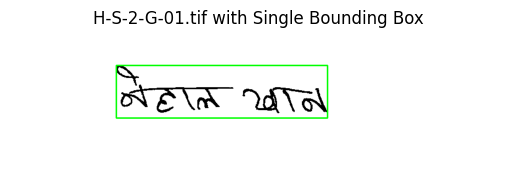

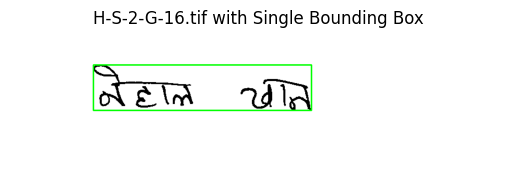

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Genuine Pair
Input : Genuine-Genuine Pair
m : tensor(9.5005, grad_fn=<AddBackward0>)
c :  tensor(9.1847, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 84.35934448242188
Threshold :  tensor(4.9508, grad_fn=<RsubBackward1>)


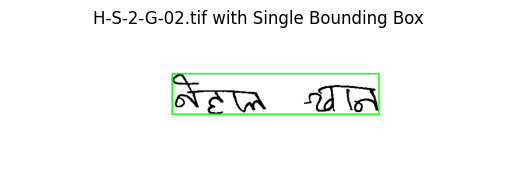

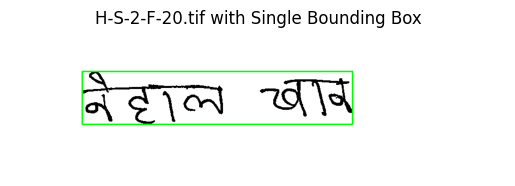

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Forged Pair
Input : Genuine-Forged Pair
m : tensor(9.9083, grad_fn=<AddBackward0>)
c :  tensor(9.7718, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 0.01865188032388687
Threshold :  tensor(5.0191, grad_fn=<AddBackward0>)


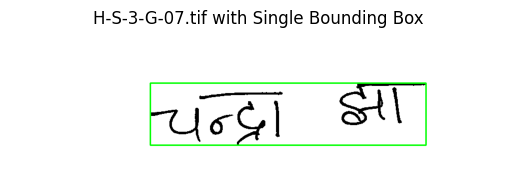

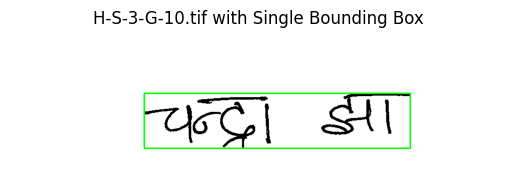

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Forged Pair
Input : Genuine-Genuine Pair
m : tensor(9.8887, grad_fn=<AddBackward0>)
c :  tensor(9.6815, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 93.73176574707031
Threshold :  tensor(9.8599, grad_fn=<AddBackward0>)


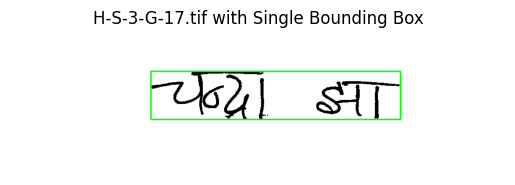

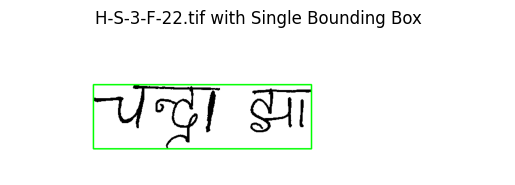

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Forged Pair
Input : Genuine-Forged Pair
m : tensor(10.2784, grad_fn=<AddBackward0>)
c :  tensor(9.8548, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 0.1794145107269287
Threshold :  tensor(10.0717, grad_fn=<AddBackward0>)


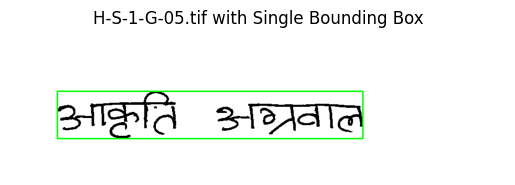

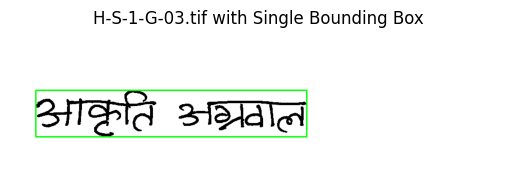

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Genuine Pair
Input : Genuine-Genuine Pair
m : tensor(9.9628, grad_fn=<AddBackward0>)
c :  tensor(9.5853, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 91.8784408569336
Threshold :  tensor(5.2790, grad_fn=<SubBackward0>)


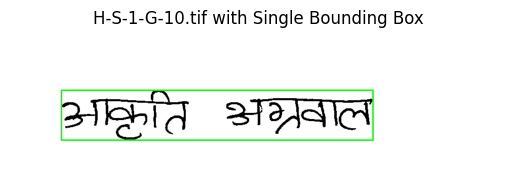

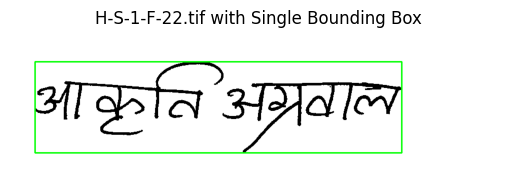

Output feature vector 1 shape : torch.Size([1, 48, 3, 9])
Output feature vector 2 shape : torch.Size([1, 48, 3, 11])
Output feature vector 3 shape : torch.Size([1, 48, 4, 13])
Output feature vector 4 shape : torch.Size([1, 48, 3, 9])
Output feature vector 5 shape : torch.Size([1, 48, 3, 11])
Output feature vector 6 shape : torch.Size([1, 48, 4, 13])
Output : Genuine-Forged Pair
Input : Genuine-Forged Pair
m : tensor(9.7335, grad_fn=<AddBackward0>)
c :  tensor(9.5375, grad_fn=<AddBackward0>)
Multi-Contrastive Loss: 0.03843959420919418
Threshold :  tensor(5.3770, grad_fn=<AddBackward0>)


In [21]:
from google.colab import drive
drive.mount('/content/drive')

# Path to the folder containing the images
directory_path = '/content/drive/MyDrive/Hindi/'

# Get a list of all the folders in the directory
folders = [folder for folder in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder))]

print(folders)

for folder_no in folders:
  count = 0;
  while count < 2:
    count += 1
    folder_path = os.path.join(directory_path, folder_no)
    # all_images = [img for img in os.listdir(folder_path) if img.endswith('.tif')]
    cropped_image_genuine_name = image_processing_genuine(int(folder_no), folder_path);
    cropped_image_genforg_name, label = image_processing_genforg(int(folder_no), folder_path);
    pipeline(cropped_image_genuine_name, cropped_image_genforg_name, label)